In [24]:
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style('white')
sns.set_context('talk')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [13]:
def genereate_conversion(x, y):
    """
    generate list of observed conversions for channel
    x :    numbere of users 
    y :    number of users that compleated conversion
    return:list of 0 and 1 integers size x 
    """
    conv_list = [0]*(x-y) + [1]*y
    random.shuffle(conv_list)
    
    return conv_list

## Generating syntetic data of conversion for 2 channels

In [51]:
channel_1 = genereate_conversion(100, 8)
channel_2 = genereate_conversion(100, 18)

In [49]:
print(channel_1[:20])
print(channel_2[:20])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Lets take a look which channel has better conversion by just taking mean 

In [23]:
print('Mean conversion for channel_1 : {} '.format(np.mean(channel_1)))
print('Mean conversion for channel_2 : {} '.format(np.mean(channel_2)))

Mean conversion for channel_1 : 0.08 
Mean conversion for channel_2 : 0.18 


Aperanntly channel_2 is better but we dont't know how sure is it better. We don't know the of unsertenty.

## Crteate the model for channel 1

In [27]:
with pm.Model() as model_channel_1:
    
    # Parameter = prior solution space. We belive that data for conv_rate falls in B distrib-n
    conversion_rate = pm.Beta("conversion_rate_1", 
                             alpha = 2., beta = 10.)
    # Binomial Likelihood
    like = pm.Binomial(
        'likelihood', 
        n=len(channel_1), 
        p=conversion_rate, 
        observed=len([x for x in channel_1 if x ==1])
    )

### Posterior solution space

In [31]:
with model_channel_1:
    plausible_values_1 = pm.sample()

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [conversion_rate_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Lets look at all possible values for conversion rate of channel 1

[0.12117667 0.10137124 0.14606312 ... 0.08392477 0.07349442 0.06895706]


C:\Program Files\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


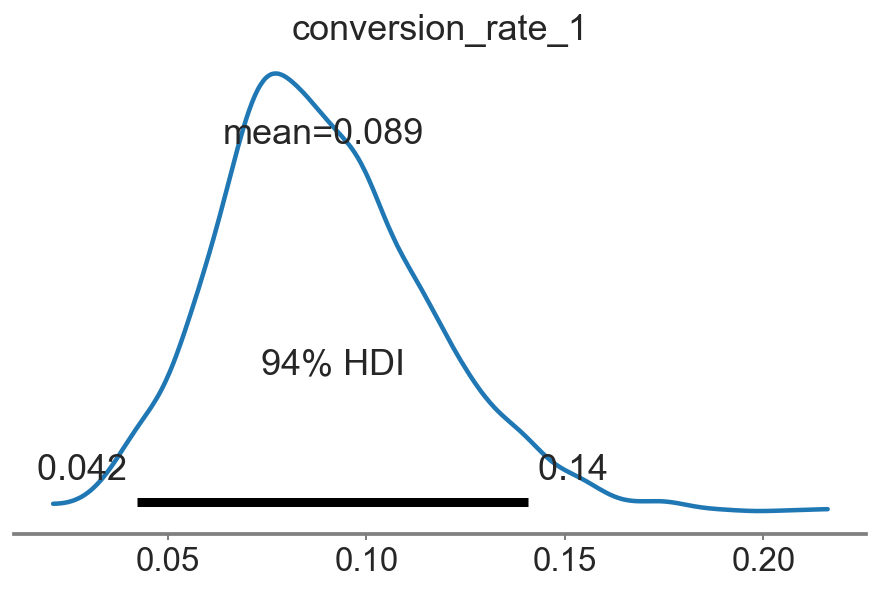

In [47]:
print(plausible_values_1['conversion_rate_1'])

# Posterior plot for bernoulli model
az.plot_posterior(plausible_values_1);

### What kind of values from conversion rate 1 are smaller then 0.1 ?

In [58]:
plausible_values_1['conversion_rate_1'] < 0.1

array([False, False, False, ...,  True,  True,  True])

### What is the probability that conversion rate from channel 1 is smaller then 10% ?

In [39]:
np.mean(plausible_values_1['conversion_rate_1'] < 0.1)*100

69.3

## Build Model: Compare $p$ for channel_1 and channel_2

Having built the model for the channel_1, let's now extend it to compare the channel_1 and channel_1.

In [54]:
with pm.Model() as model2:
    
    # Parameter = prior solution space. We belive that data for conv_rate falls in B distrib-n
    conversion_rate_1 = pm.Beta("conversion_rate_1", 
                             alpha = 2., beta = 10.)
    # Binomial Likelihood
    like_1 = pm.Binomial(
        'like_channel_1', 
        n=len(channel_1), 
        p=conversion_rate_1, 
        observed=len([x for x in channel_1 if x ==1])
    )
    
    # Modify the above p and likelihood for channel 2.
    conversion_rate_2 = pm.Beta("conversion_rate_2", 
                             alpha = 2., beta = 10.)
    # Binomial Likelihood
    like_2 = pm.Binomial(
        'like_channel_2', 
        n=len(channel_2), 
        p=conversion_rate_2, 
        observed=len([x for x in channel_2 if x ==1])
    )
    
    # We will also explicitly compute the difference between
    # p_channel_1 and p_channel_2. 
    # This shows you that we can do math on probability distributions!
    
    conv_diff = pm.Deterministic("conv_diff", conversion_rate_2 - conversion_rate_1)

In [55]:
with model2:
    plausible_values = pm.sample()

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [conversion_rate_2, conversion_rate_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.


C:\Program Files\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


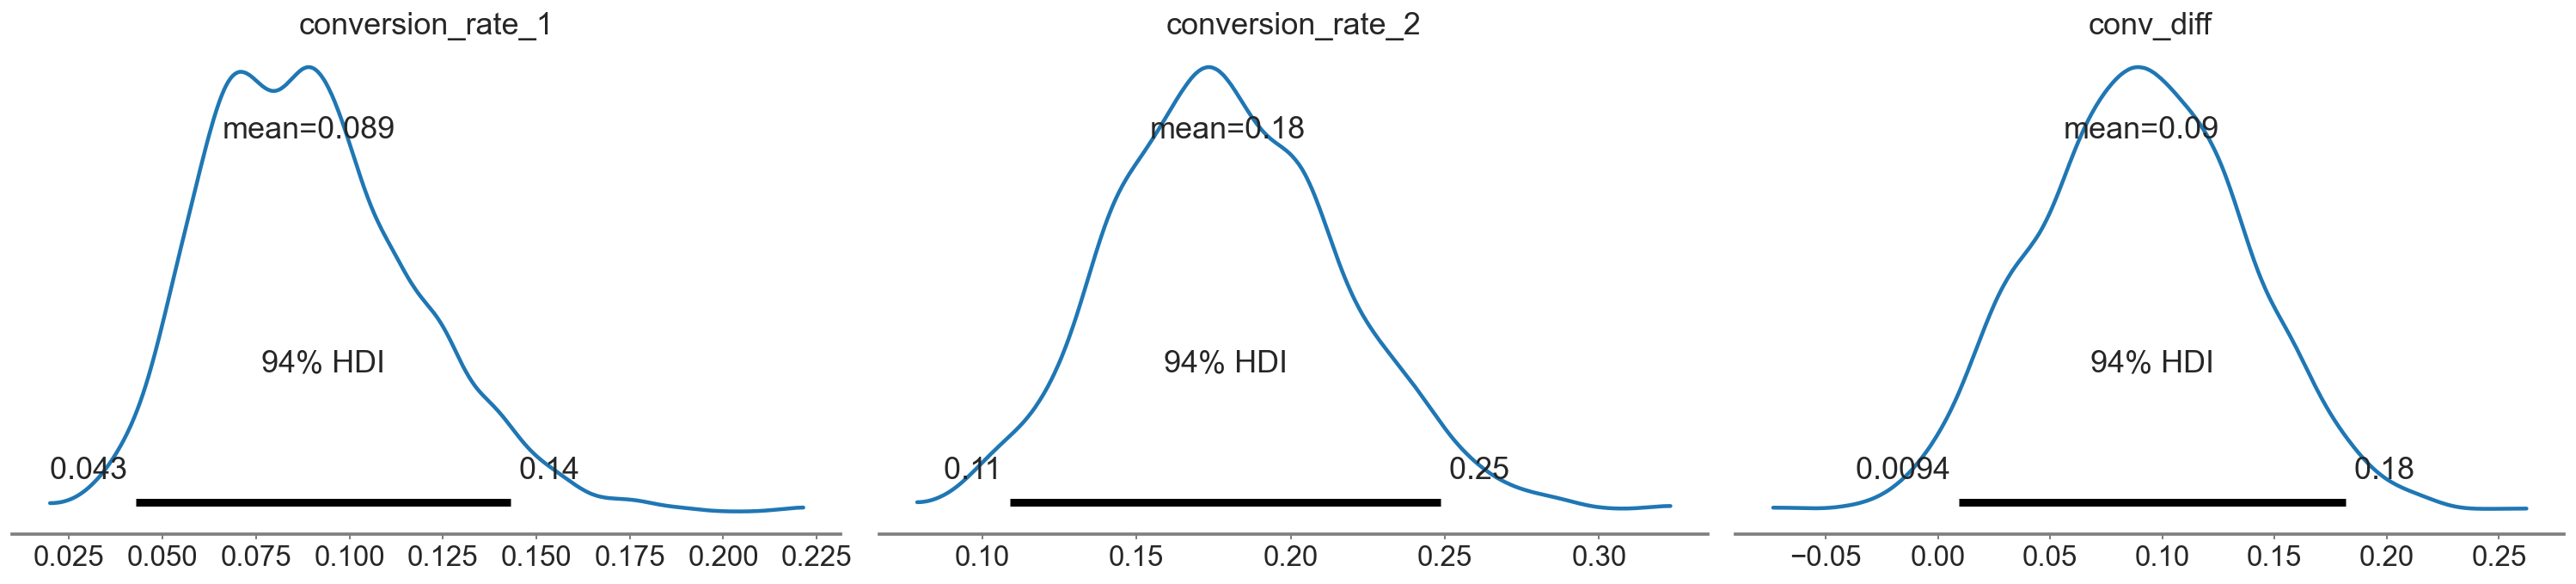

In [56]:
az.plot_posterior(plausible_values);

# From KDE plot # 3 we can tell that probability that conversion rate of channel 1 larger then channel 2 is 9%

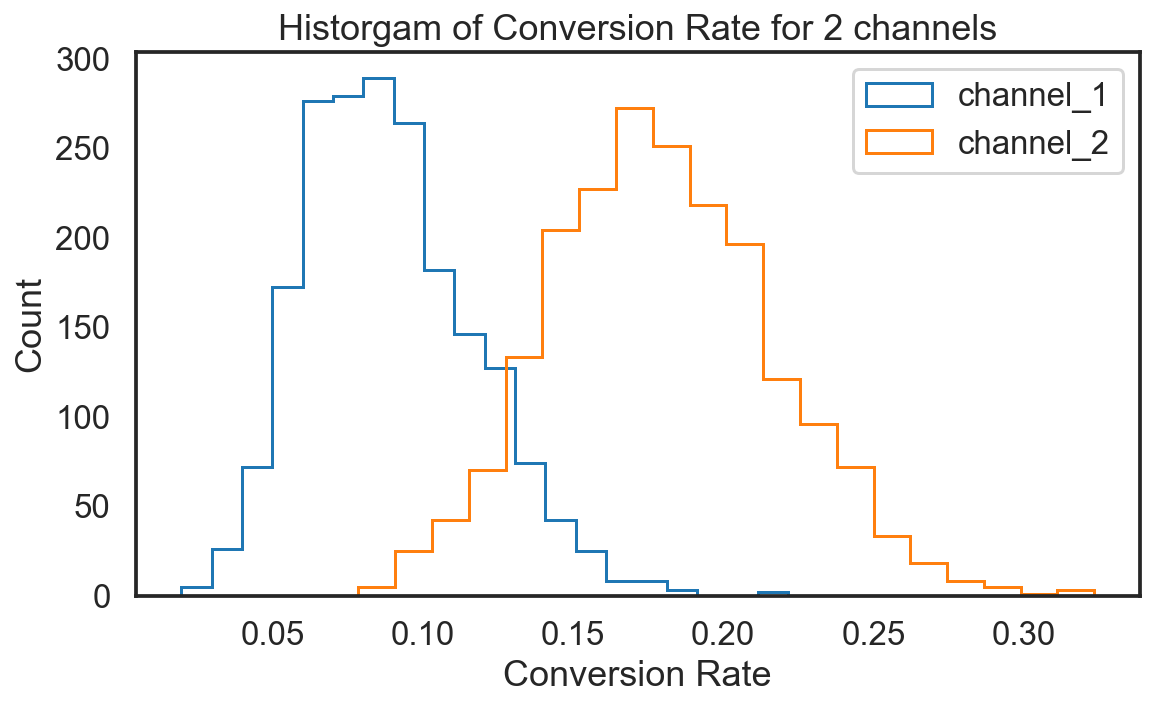

In [72]:
fig, ax = plt.subplots(figsize = (9,5))

ax.hist(plausible_values['conversion_rate_1'], label="channel_1", bins=20, histtype='step')
ax.hist(plausible_values['conversion_rate_2'], label="channel_2", bins=20, histtype='step')

ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Count')
ax.set_title('Historgam of Conversion Rate for 2 channels')

ax.legend()
plt.show()

### What is the probability that the conversion rate channel_2 better then channel_1

In [77]:
diff = plausible_values['conversion_rate_1'] > plausible_values['conversion_rate_2']

In [78]:
np.mean(diff)

0.022